<center><h1>WineReviews_TextMining<h1></center>
<h4>Motivation</h4>
<p>In the past few decades, the production and consumption of alcohol has increased dramatically.https://www.svb.com/trends-insights/reports/wine-report/2018-svb-wine-report/ </p>
    <img src="wineComsuption.jpg" height="720" width="90%">
<p>With the increaseing of wine consumption, more and more manufacturers joinied this industry. The num of wines' brand also raised up significantly. https://winefornormalpeople.com/there-are-too-many-wine-brands-in-the-world/ There are people complain it's hard to distinguish great wine within so many options. Even you can find a lot of lists like "most disgusting alcoholic, you should never try, but it could guarantee you could avoid buying wine which is not your style. And the new brands are alwasy coming on the way. So how to pick up a great wine best for you. Can we get some hints from some basic information like the description in the container. That's what I want to dig into in this project </p>
<p></p>
<p></p>
<hr>
<h4>Dataset</h4>
<p>This dataset - wine reviews was collected from Kaggle, https://www.kaggle.com/zynicide/wine-reviews</p>
<p>The orginal dataset contains 14 features and 129971 data instances</p>
<p>Size of the dataset is </p>
<p>The 14 features are 51,700 kb</p>
<p>'Unnamed', 'country', 'description', 'designation', 'points',
       'price', 'province', 'region_1', 'region_2', 'taster_name',
       'taster_twitter_handle', 'title', 'variety', 'winery'</p>
<p></p>
<p>Each row in the dataset represent a review for one wine. And there exist some duplicated record for same wine.</p>   
<hr>
<h4>Guiding Questions</h4>
<p> 1. Are wines' price different between place of origin(country? In other word, does producer in different countries has preferred price range?</p>
<p>2. Does wines' producer has sepecfic pricing strategy? Or does they prefer to price their wine for sepecfic reason?</p>
<p>3. Can we predict wines' potential points based on their description? If a new brand of wine come to market, could we give it accruate ranking before some professional taster try it?</p>

In [189]:
#global import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pylab 
from matplotlib.pylab import plt
from sklearn import cross_validation
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
import keras
import os
import time
from keras.models import Sequential
from keras.layers import Dense, Dropout, MaxPooling1D, AveragePooling1D, Activation
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import InputLayer

<center><h4>Data Import & processing & exploration</h4></center>

In [2]:
#Data Import & prerocessing
reviews = pd.read_csv('winemag-data-130k-v2.csv')
reviews.drop(columns=['Unnamed: 0', 'province', 'region_1', 'region_2', 'taster_name', 'taster_twitter_handle'], inplace=True)
#drop outliers too and duplicates
reviews = reviews[reviews['price']<100]
reviews = reviews.drop_duplicates(['title','description'])
reviews.head(5)

,country,description,designation,points,price,title,variety,winery
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem


Text(0.5,1,'origin distribtion')

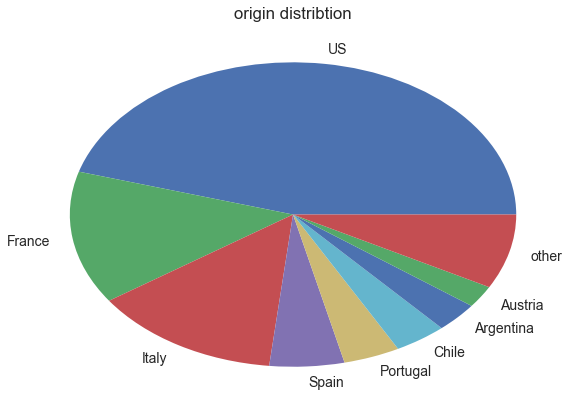

In [148]:
#distribution of Country
distribution = {}
countrys = reviews['country'].value_counts().keys()
nums = reviews['country'].value_counts().values
for i in range(0,8):
    distribution[countrys[i]] = nums[i]
distribution['other'] = sum(nums[8:])
plt.figure(figsize = (10,7))
plt.pie(distribution.values(), labels=distribution.keys())
plt.title("origin distribtion")

<BarContainer object of 21 artists>

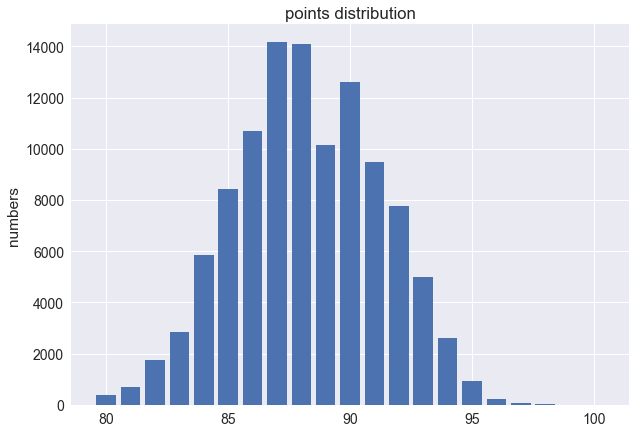

In [138]:
#distribtuion of points
points =  reviews['points'].value_counts().keys()
nums = reviews['points'].value_counts().values
plt.figure(figsize = (10,7))
plt.ylabel('numbers')
plt.title('points distribution')
plt.bar(points, nums)
## gaussian distribution which make perfect sense

<BarContainer object of 96 artists>

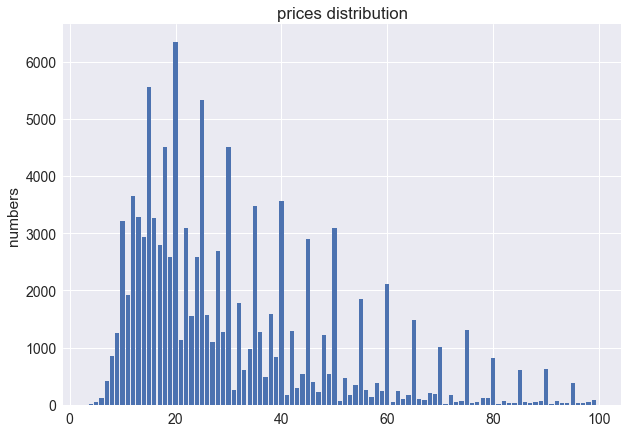

In [150]:
prices =  reviews['price'].value_counts().keys()
nums = reviews['price'].value_counts().values
plt.figure(figsize = (10,7))
plt.ylabel('numbers')
plt.title('prices distribution')
plt.bar(prices, nums)

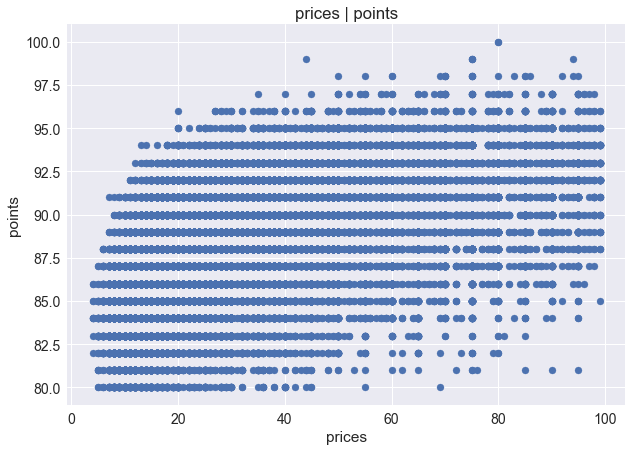

In [145]:
plt.figure(figsize = (10,7))

plt.xlabel('prices')
plt.ylabel('points')
plt.title('prices | points')
plt.scatter(reviews['price'], reviews['points'])

<center><h4>Guiding Question 1</h4></center>
<h4>question1:</h4>
<p>Are wines' price different between place of origin(country)? In other word, does producer in different countries has preferred price range</p>
<hr>
<h4>Preprocessing</h4>
<p>Since there are total 43 country, and we may not be able to visualize all of these countries. So at the last, we would just choose several country to do visualization. And all duplicated data instance have to be removed in order to get accurate result<P>
<hr>
<h4>Result Summary</h4>
    <p>By converting country to categorical variable, and using coding represetation. We could get the correlation between country, price and points. Unfortuanly, the correlation between country and porice is low to be proven that they are high correlated. But by doing some visualiztion, we still find some clues that some country may prefer some price. The overall trend is increasing initailly, and the wines amound decrease when the price continue increasing. But each country may decrease from different points. For example, wines from Portugal are mostly in low price range. Italy wines have a more balanced distribution. The variance between price and how many wines are in that price of Italy wines is lower than other countries'</p>
<p></p>

          country    points     price
country  1.000000  0.036119  0.119687
points   0.036119  1.000000  0.552579
price    0.119687  0.552579  1.000000


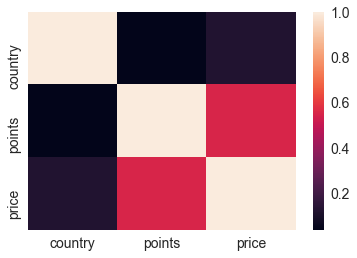

In [155]:
#Preprocessing
question1 = reviews.copy()
corr=question1.assign(country=question1.country.astype('category').cat.codes).corr()
print(corr)
sns.heatmap(corr)

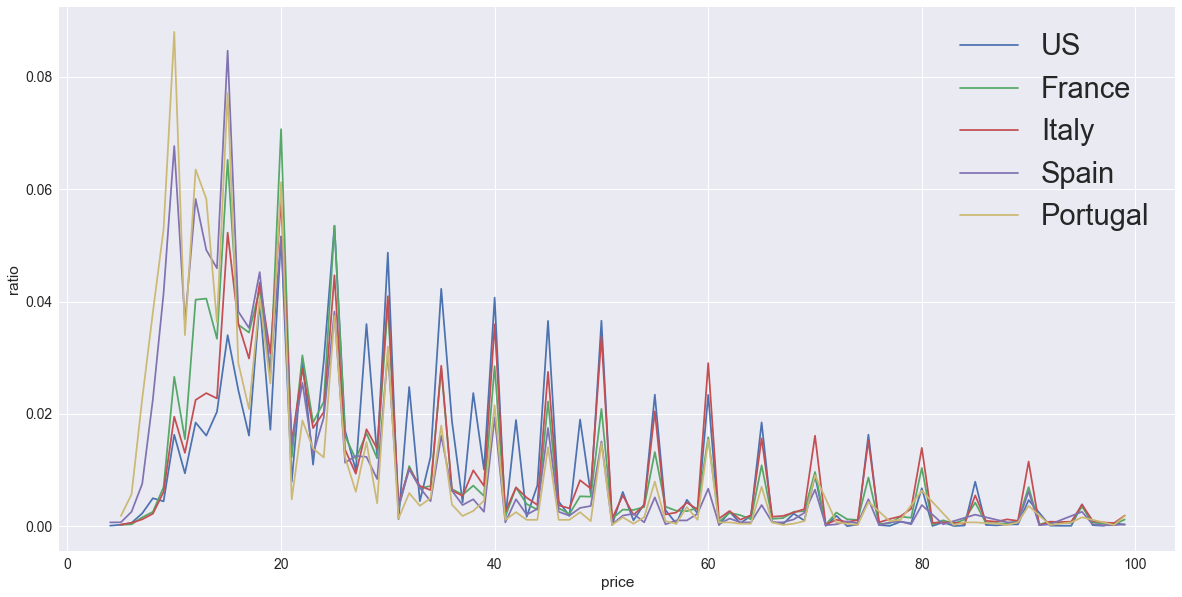

In [167]:
question1 = reviews.copy()
top_10_countries=question1['country'].value_counts().keys()[:5]
plt.figure(figsize=(20,10))
plt.xlabel('price')
plt.ylabel('ratio')
for country in top_10_countries:
    prices_count = np.unique(question1[question1['country'] == country]['price'], return_counts=True)
    pylab.plot(prices_count[0], prices_count[1]/len(question1[question1['country'] == country]), label=country)
pylab.legend(loc='upper right', fontsize='xx-large')

<center><h4>Guiding Question 2</h4></center>
<h4>Question2: </h4>
<p>Does wines' producer has sepecfic pricing strategy? Or does they prefer price their wine for sepecfic reason?</p>
<hr>
<p>From visualizing the price distirbution. I found there are a lot of peaks which are more wines in that price. And I tried to catch the pattern and tried to explain the trend with some simple regression models.</p>
<hr>
<h4>Preprocessing</h4>
<p>In my models, the independent variables are price and whether this price can be devided by 5. Because I realized there are more wines when the price is integer multiple of five. So I make a feature generation to create a binary variable of 'modby5'</p>
<hr>
<h4>result summary</h4>
<p>Feature of modby5 did catch the change significantly. With visualizing the result, you can easily find all peaks were tracked by models. And Low degree models also made very great work. All model got R square higher than 0.7. And ploynomial models with degree 4 played very well job to predict the distribution</p>

In [259]:
def visualize_model(y_predict, model_name):
    plt.figure(figsize = (10,2))
    plt.title(model_name)
    plt.xlabel("prices")
    plt.ylabel("count")
    plt.scatter(prices_distribution['price'], prices_distribution['count'],  color='red')
    plt.plot(prices_distribution['price'], y_predict, color='blue', linewidth=2)
    plt.show()

In [230]:
#preprocessing
prices_distribution = pd.DataFrame(reviews.groupby('price')['description'].count())
prices_distribution.reset_index(inplace=True)
prices_distribution['modby5']=0
prices_distribution.ix[prices_distribution['price']%5==0, 'modby5'] = 1
prices_distribution.columns=['price', 'count','modby5']
prices_distribution.head(5)

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


,price,count,modby5
0,4.0,11,0
1,5.0,44,1
2,6.0,115,0
3,7.0,413,0
4,8.0,859,0


<BarContainer object of 96 artists>

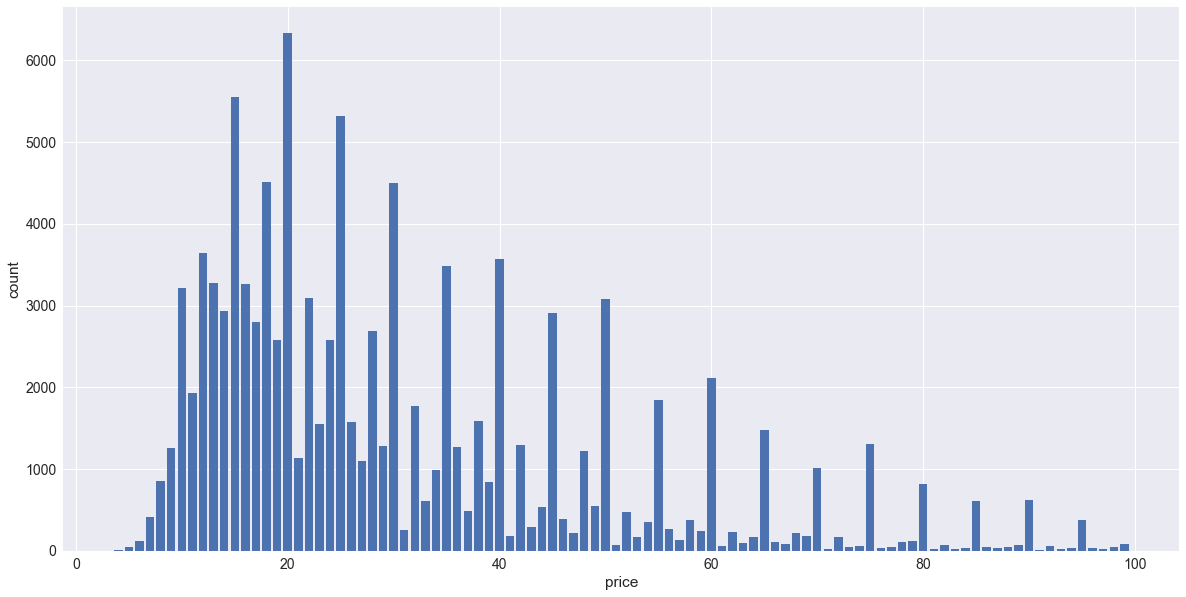

In [231]:
plt.figure(figsize=(20,10))
plt.xlabel('price')
plt.ylabel('count')
plt.bar(prices_distribution['price'], prices_distribution['count'])

<h4>one degree linear model & 5 folders cross validation</h4>

In [275]:
#Cross validation and model preparation
kf = cross_validation.KFold(len(prices_distribution), n_folds=5, shuffle=True)
x = prices_distribution[['price','modby5']].as_matrix()
y = prices_distribution['count'].as_matrix()

poly = PolynomialFeatures(4)
x_poly_4 = poly.fit_transform(prices_distribution[['price','modby5']])
poly = PolynomialFeatures(3)
x_poly_3 = poly.fit_transform(prices_distribution[['price','modby5']])

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [267]:
 #train linear model and visualize its result
models=[]
for train_index, test_index in kf:
    start = time.time()
    model = LinearRegression().fit(x[train_index], y[train_index])
    model_score = model.score(x[test_index], y[test_index])
    y_predict = model.predict(x[test_index])
    regression_model_mse = mean_squared_error(y_predict, y[test_index])
    models.append({'model' : model, 'y_predict':model.predict(x)})
    print("Time taken is " + str(time.time()-start))
    print("R square is " + str(model_score))
    print("The prediction mse is " + str(regression_model_mse))

Time taken is 0.002004861831665039
R square is 0.10034162013616808
The prediction mse is 2249960.3744045356
Time taken is 0.0015041828155517578
R square is 0.7744949981523618
The prediction mse is 301713.37902450433
Time taken is 0.0010035037994384766
R square is 0.3175019486880327
The prediction mse is 1060297.3545199065
Time taken is 0.0005002021789550781
R square is 0.748968964302101
The prediction mse is 504873.710785356
Time taken is 0.0004928112030029297
R square is 0.7136047917403772
The prediction mse is 650193.9179187608


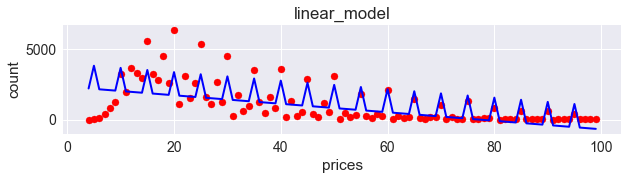

In [268]:
visualize_model(models[1]['y_predict'], 'linear_model')

In [276]:
#fit data with Polynomial model, set its degrees to 2, and visualize its result
models=[]
for train_index, test_index in kf:
    start = time.time()
    model = LinearRegression().fit(x_poly_4[train_index], y[train_index])
    model_score = model.score(x_poly_4[test_index], y[test_index])
    y_predict = model.predict(x_poly_4[test_index])
    regression_model_mse = mean_squared_error(y_predict, y[test_index])
    models.append({'model' : model, 'y_predict':model.predict(x_poly_4)})
    print("Time taken is " + str(time.time()-start))
    print("R square is " + str(model_score))
    print("The prediction mse is " + str(regression_model_mse))

Time taken is 0.0015041828155517578
R square is 0.8722270868059306
The prediction mse is 322683.3101561715
Time taken is 0.0015060901641845703
R square is 0.7909745405715993
The prediction mse is 438415.5618090451
Time taken is 0.001001596450805664
R square is 0.6249652363208348
The prediction mse is 661572.9045359906
Time taken is 0.0010030269622802734
R square is 0.8682082670841325
The prediction mse is 339882.8475608697
Time taken is 0.0010027885437011719
R square is 0.756149406316596
The prediction mse is 264690.6166164976


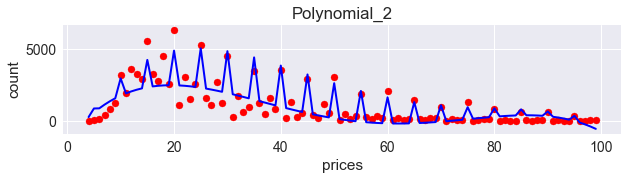

In [277]:
visualize_model(models[0]['y_predict'], 'Polynomial_2')

In [273]:
#fit data with Polynomial model, set its degrees to 2, and visualize its result
models=[]
for train_index, test_index in kf:
    start = time.time()
    model = LinearRegression().fit(x_poly_3[train_index], y[train_index])
    model_score = model.score(x_poly_3[test_index], y[test_index])
    y_predict = model.predict(x_poly_3[test_index])
    regression_model_mse = mean_squared_error(y_predict, y[test_index])
    models.append({'model' : model, 'y_predict':model.predict(x_poly_3)})
    print("Time taken is " + str(time.time()-start))
    print("R square is " + str(model_score))
    print("The prediction mse is " + str(regression_model_mse))

Time taken is 0.0014925003051757812
R square is -0.3867872873194502
The prediction mse is 3468223.621358345
Time taken is 0.001003265380859375
R square is 0.8147187643489326
The prediction mse is 247896.17622711931
Time taken is 0.001003265380859375
R square is 0.49867880818662014
The prediction mse is 778829.3789596829
Time taken is 0.0005009174346923828
R square is 0.8321140573561856
The prediction mse is 337652.26923289726
Time taken is 0.0005009174346923828
R square is 0.6951693084318493
The prediction mse is 692047.4083941724


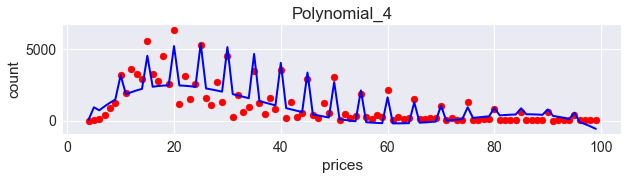

In [278]:
visualize_model(models[3]['y_predict'], 'Polynomial_4')

<center><h4>Guiding Question 3</h4></center>
<h4>Question3: </h4>
<p>Can we predict a potential score for a new Wine just based on it's description?</p>
<hr>
<h4>Preprocessing</h4>
<p>Approach 1: Simply embedded Wine descriptions as input, discretized the points as target attibute. Apllied shallow three layers nerual network as model and get 5 models through 5-folder-cross-validation. Set two kinds of experiment, one building models without pool layer, the another one making model with a pooling process.</p>

<p>Approach 2: Combine country and price to description. Then made same steps as approach 1.</p>
<hr>
<h4> Result Summary </h4>
<p>All models could get overall accruacy around 0.7. By adding infomation like country or price doesn't help improve the accuracy a lot. It make perfect sense since no one would say bad word in their own production's description. Adding pooling layer doesn't help too much as well. But it could resolve traning overfitting, and by using 1D pooling, it decrease running significantly. So pooling could be used not just for cleaning noise but also help to speed up model construction. </p>

In [69]:
def visualize_history(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylim([0.5, 1])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
#def draw_confusion_matrix(model):
def draw_confusion_matrix(labels, prediction):
    cm = np.zeros((5, 5), dtype=int)
    np.add.at(cm, [labels, prediction], 1)
    print(cm)
    df_cm = pd.DataFrame(cm)
    plt.figure(figsize = (10,7))
    plt.title('Confusion Matrix of model prediction')
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu")
    plt.show()

In [4]:
#prepare embedding matrix
embeddings_index = {}
f = open('glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


<h5>approach 1 : building model without country and price information</h5>

In [5]:
#prepare dataset discrilize points to ranking
reviews_text_mining=reviews.copy()
reviews_text_mining['ranking'] = pd.cut(reviews_text_mining['points'], bins=[0,80, 85, 90, 95, 101], labels=[0,1,2,3,4])
reviews_text_mining.head(5)

tokenizer = Tokenizer(num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(reviews_text_mining['description'])
sequences = tokenizer.texts_to_sequences(reviews_text_mining['description'])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences)

labels = reviews_text_mining['ranking']
labelsEncode =keras.utils.to_categorical(labels, num_classes=5 ,dtype="int32")
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 35269 unique tokens.
Shape of data tensor: (107808, 128)
Shape of label tensor: (107808,)


In [6]:
#prepare embbedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [16]:
models=[]
#prepare 5 folds validation
kf = KFold(n_splits=5, shuffle=True)
kf.get_n_splits(data)
for train_index, test_index in kf.split(data):
    #construct model
    model = Sequential()
    start = time.time();
    e = Embedding(input_dim=35270, output_dim=100, input_length=128, weights=[embedding_matrix], trainable=False)
    model.add(e)
    model.add(Flatten())
    model.add(Dense(5, activation='sigmoid'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    #start training
    history = model.fit(data[train_index], labelsEncode[train_index], batch_size=1024, validation_split=0.2, epochs=10, verbose=0)
    prediction_acc = model.evaluate(data[test_index], labelsEncode[test_index])
    print('test accuracy is: ' + str(prediction_acc))
    models.append({'history':history, 'model':model, 'prediction_acc':prediction_acc, 'time':time.time()-start})

21562/21562 [==============================] - 1s 30us/step
test accuracy is: [0.749453617539922, 0.6723866060551703]
21562/21562 [==============================] - 1s 31us/step
test accuracy is: [0.7496094546383514, 0.6685836193524181]
21562/21562 [==============================] - 1s 30us/step
test accuracy is: [0.7674831736343224, 0.6653835451256841]
21561/21561 [==============================] - 1s 32us/step
test accuracy is: [0.7584438036525467, 0.6681508278712388]
21561/21561 [==============================] - 1s 31us/step
test accuracy is: [0.7671262611153451, 0.6600807012495883]


In [18]:
for model in models:
    print(model['prediction_acc'])

[0.749453617539922, 0.6723866060551703]
[0.7496094546383514, 0.6685836193524181]
[0.7674831736343224, 0.6653835451256841]
[0.7584438036525467, 0.6681508278712388]
[0.7671262611153451, 0.6600807012495883]


In [19]:
models[0]['model'].evaluate(data, labelsEncode)

107808/107808 [==============================] - 3s 32us/step


[0.6656674509340027, 0.7033429801127931]

In [20]:
print('time taken for this model: ' +str(models[0]['time']))

time taken for this model: 31.077526330947876


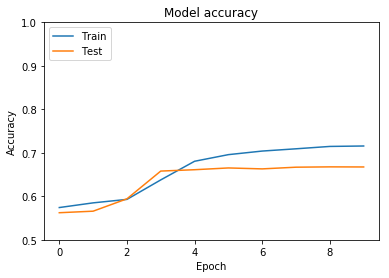

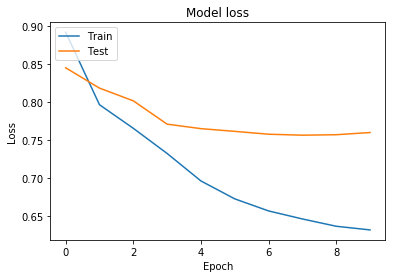

In [21]:
visualize_history((models[1]['history']))

In [25]:
#get prediction labels
prediction = models[0]['model'].predict(data)
prediction = prediction.argmax(axis=-1)
prediction

array([2, 2, 2, ..., 2, 2, 2], dtype=int64)

[[   16     0     0     0     0]
 [  321  8536  3475   128     0]
 [   57 10857 53565 12025    44]
 [    1   150  4694 13616   218]
 [    0     0     0    12    93]]


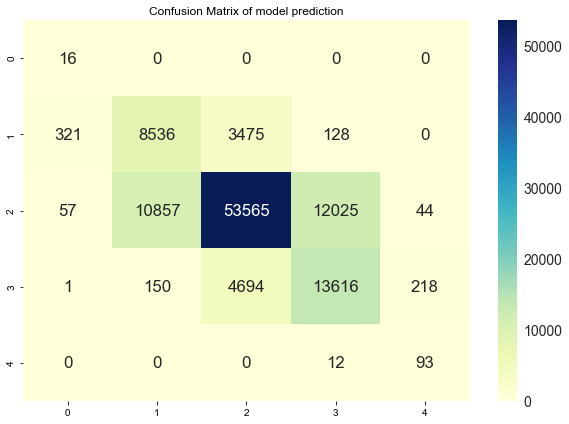

In [31]:
#draw confusion matrix
draw_confusion_matrix(prediction, reviews_text_mining['ranking'])

<h5>Adding a pooling layers</h5>

In [33]:
models=[]
#prepare 5 folds validation
kf = KFold(n_splits=5, shuffle=True)
kf.get_n_splits(data)
for train_index, test_index in kf.split(data):
    #construct model, adding a pooling layer
    model = Sequential()
    start = time.time()
    e = Embedding(input_dim=35270, output_dim=100, input_length=128, weights=[embedding_matrix], trainable=False)
    model.add(e)
    model.add(MaxPooling1D(pool_size=15, padding='valid', data_format='channels_last'))
    model.add(Flatten())
    model.add(Dense(5, activation='sigmoid'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    #start training
    history = model.fit(data[train_index], labelsEncode[train_index], batch_size=1024, validation_split=0.2, epochs=10, verbose=0)
    prediction_acc = model.evaluate(data[test_index], labelsEncode[test_index])
    print('test accuracy is: ' + str(prediction_acc)) 
    models.append({'history':history, 'model':model, 'prediction_acc':prediction_acc, 'time':time.time()-start})

21562/21562 [==============================] - 1s 27us/step
test accuracy is: [0.819631009445309, 0.634588628175274]
21562/21562 [==============================] - 1s 27us/step
test accuracy is: [0.8211825764164855, 0.6329190241871423]
21562/21562 [==============================] - 1s 26us/step
test accuracy is: [0.822524846164053, 0.6361654763340718]
21561/21561 [==============================] - 1s 27us/step
test accuracy is: [0.8242139930207811, 0.6303974769093443]
21561/21561 [==============================] - 1s 27us/step
test accuracy is: [0.8106214606962633, 0.6376791428996617]


In [34]:
for model in models:
    print(model['prediction_acc'])

[0.819631009445309, 0.634588628175274]
[0.8211825764164855, 0.6329190241871423]
[0.822524846164053, 0.6361654763340718]
[0.8242139930207811, 0.6303974769093443]
[0.8106214606962633, 0.6376791428996617]


In [35]:
models[4]['model'].evaluate(data, labelsEncode)

107808/107808 [==============================] - 3s 29us/step


[0.8146712198990607, 0.6366225140991392]

In [36]:
print('time taken for this model: ' +str(models[0]['time']))

time taken for this model: 20.46827793121338


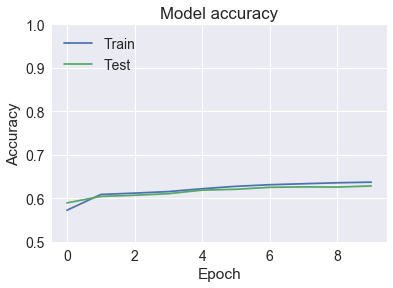

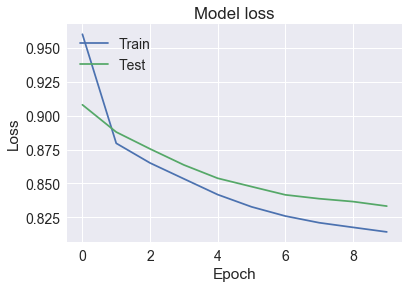

In [42]:
visualize_history(models[4]['history'])

In [43]:
#get prediction labels
prediction = models[4]['model'].predict(data)
prediction = prediction.argmax(axis=-1)
prediction

array([2, 2, 2, ..., 2, 2, 2], dtype=int64)

[[    0     0     0     0     0]
 [  250  5189  2798    91     1]
 [  137 14032 53984 16236    62]
 [    8   322  4952  9454   286]
 [    0     0     0     0     6]]


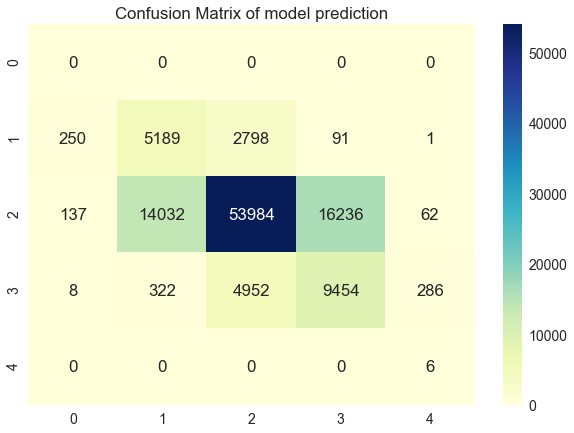

In [44]:
draw_confusion_matrix(prediction, reviews_text_mining['ranking'])

<h5>appoarch 2: building model with country and price</h5>

In [45]:
#data processing, discitlize price into 4 category - cheap, normal, affordable, expensive
#append price and country to description
reviews_text_mining = reviews.copy()
reviews_text_mining['ranking'] = pd.cut(reviews_text_mining['points'], bins=[0,80, 85, 90, 95, 101], labels=[0,1,2,3,4])
reviews_text_mining['price_ranking'] = pd.cut(reviews_text_mining['points'], bins=[0,20,40,60,100], labels=['price is cheap','price is normal','price is affordable','price is expensive'])
reviews_text_mining['country'] = 'made in ' + reviews_text_mining['country']
reviews_text_mining['description']=reviews_text_mining[['country', 'price_ranking', 'description']].apply(lambda x : '{} {} {}'.format(x[0],x[1], x[2]), axis=1)
reviews_text_mining.head(5)

,country,description,designation,points,price,title,variety,winery,ranking,price_ranking
1,made in Portugal,made in Portugal price is expensive This is ri...,Avidagos,87,15.0,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,2,price is expensive
2,made in US,"made in US price is expensive Tart and snappy,...",NaN,87,14.0,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,2,price is expensive
3,made in US,"made in US price is expensive Pineapple rind, ...",Reserve Late Harvest,87,13.0,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2,price is expensive
4,made in US,made in US price is expensive Much like the re...,Vintner's Reserve Wild Child Block,87,65.0,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2,price is expensive
5,made in Spain,made in Spain price is expensive Blackberry an...,Ars In Vitro,87,15.0,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,2,price is expensive


In [46]:
tokenizer = Tokenizer(num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(reviews_text_mining['description'])
sequences = tokenizer.texts_to_sequences(reviews_text_mining['description'])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences)

labels = reviews_text_mining['ranking']
labelsEncode =keras.utils.to_categorical(labels, num_classes=5 ,dtype="int32")
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 35276 unique tokens.
Shape of data tensor: (107808, 134)
Shape of label tensor: (107808,)


In [47]:
#prepare embbedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [49]:
models=[]
#prepare 5 folds validation
kf = KFold(n_splits=5, shuffle=True)
kf.get_n_splits(data)
for train_index, test_index in kf.split(data):
    #construct model
    model = Sequential()
    start = time.time()
    e = Embedding(input_dim=35277, output_dim=100, input_length=134, weights=[embedding_matrix], trainable=False)
    model.add(e)
    model.add(Flatten())
    model.add(Dense(5, activation='sigmoid'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    #start training
    history = model.fit(data[train_index], labelsEncode[train_index], batch_size=1024, validation_split=0.2, epochs=10, verbose=0)
    prediction_acc = model.evaluate(data[test_index], labelsEncode[test_index])
    print('test accuracy is: ' + str(prediction_acc)) 
    models.append({'history':history, 'model':model, 'prediction_acc':prediction_acc, 'time':time.time()-start})

21562/21562 [==============================] - 1s 35us/step
test accuracy is: [0.7249067516895694, 0.6774417957296709]
21562/21562 [==============================] - 1s 33us/step
test accuracy is: [0.7565766444410578, 0.6692329097375745]
21562/21562 [==============================] - 1s 40us/step
test accuracy is: [0.7491810944447236, 0.6683517299228293]
21561/21561 [==============================] - 1s 34us/step
test accuracy is: [0.7500822009229079, 0.6693567088752658]
21561/21561 [==============================] - 1s 35us/step
test accuracy is: [0.7557808200203141, 0.6698205092362308]


In [50]:
for model in models:
    print(model['prediction_acc'])

[0.7249067516895694, 0.6774417957296709]
[0.7565766444410578, 0.6692329097375745]
[0.7491810944447236, 0.6683517299228293]
[0.7500822009229079, 0.6693567088752658]
[0.7557808200203141, 0.6698205092362308]


In [51]:
models[0]['model'].evaluate(data, labelsEncode)

107808/107808 [==============================] - 4s 36us/step


[0.6573989886086148, 0.7064225289403384]

In [52]:
print('time taken for this model: ' +str(models[0]['time']))

time taken for this model: 34.17920184135437


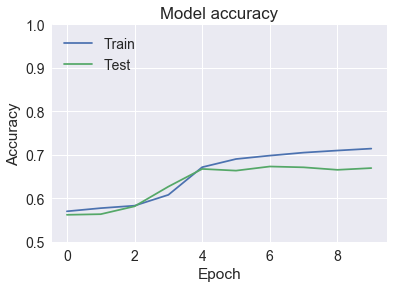

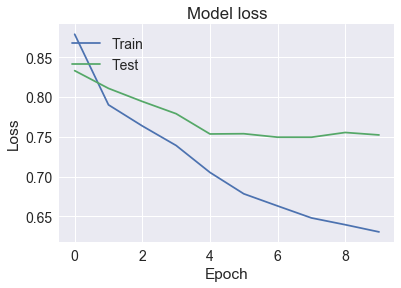

In [56]:
visualize_history(models[0]['history'])

In [57]:
#get prediction labels
prediction = models[0]['model'].predict(data)
prediction = prediction.argmax(axis=-1)
prediction

array([2, 2, 2, ..., 2, 2, 2], dtype=int64)

[[    8     1     0     0     0]
 [  330  8838  3610   120     0]
 [   55 10527 52714 11157    41]
 [    2   177  5409 14500   263]
 [    0     0     1     4    51]]


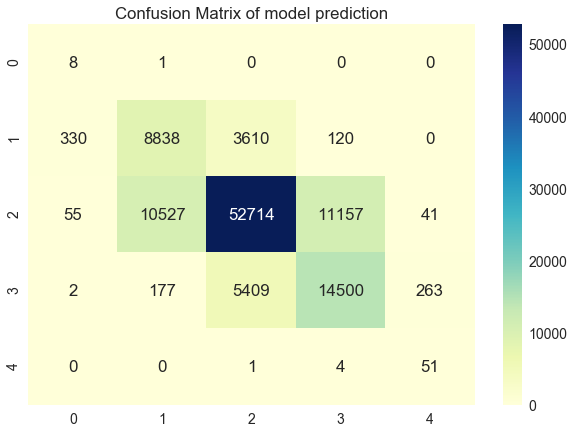

In [58]:
draw_confusion_matrix(prediction, reviews_text_mining['ranking'])

<h5>adding a pooling layer</h5>

In [60]:
models=[]
#prepare 5 folds validation
kf = KFold(n_splits=5, shuffle=True)
kf.get_n_splits(data)
for train_index, test_index in kf.split(data):
    #construct model
    model = Sequential()
    start=time.time()
    e = Embedding(input_dim=35277, output_dim=100, input_length=134, weights=[embedding_matrix], trainable=False)
    model.add(e)
    model.add(MaxPooling1D(pool_size=15, padding='valid', data_format='channels_last'))
    model.add(Flatten())
    model.add(Dense(5, activation='sigmoid'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    #start training
    history = model.fit(data[train_index], labelsEncode[train_index], batch_size=1024, validation_split=0.2, epochs=10, verbose=0)
    prediction_acc = model.evaluate(data[test_index], labelsEncode[test_index])
    print('test accuracy is: ' + str(prediction_acc)) 
    models.append({'history':history, 'model':model, 'prediction_acc':prediction_acc, 'time':time.time()-start})

21562/21562 [==============================] - 1s 29us/step
test accuracy is: [0.8276950747932931, 0.6277710787441235]
21562/21562 [==============================] - 1s 30us/step
test accuracy is: [0.8189434658761215, 0.6333364252145829]
21562/21562 [==============================] - 1s 28us/step
test accuracy is: [0.8204944352970507, 0.6343103608531331]
21561/21561 [==============================] - 1s 30us/step
test accuracy is: [0.8160784729314057, 0.6367979221521805]
21561/21561 [==============================] - 1s 30us/step
test accuracy is: [0.8223679536326985, 0.6312786976761767]


In [63]:
for model in models:
    print(model['prediction_acc'])

[0.8276950747932931, 0.6277710787441235]
[0.8189434658761215, 0.6333364252145829]
[0.8204944352970507, 0.6343103608531331]
[0.8160784729314057, 0.6367979221521805]
[0.8223679536326985, 0.6312786976761767]


In [64]:
models[3]['model'].evaluate(data, labelsEncode)

107808/107808 [==============================] - 3s 29us/step


[0.8166231800342887, 0.6371976105669338]

In [65]:
print('time taken for this model: ' +str(models[3]['time']))

time taken for this model: 21.427348136901855


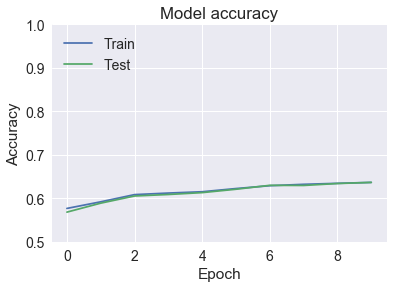

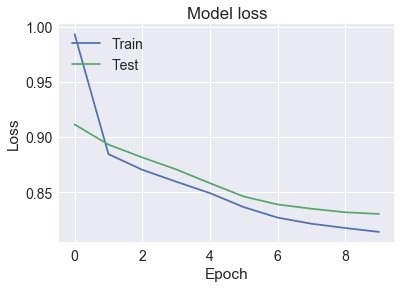

In [68]:
visualize_history(models[3]['history'])

In [70]:
prediction = models[0]['model'].predict(data)
prediction = prediction.argmax(axis=-1)
prediction

array([2, 2, 2, ..., 2, 2, 2], dtype=int64)

[[    0     0     0     0     0]
 [  234  4660  2486    90     1]
 [  157 14574 54330 16402    64]
 [    4   309  4917  9281   281]
 [    0     0     1     8     9]]


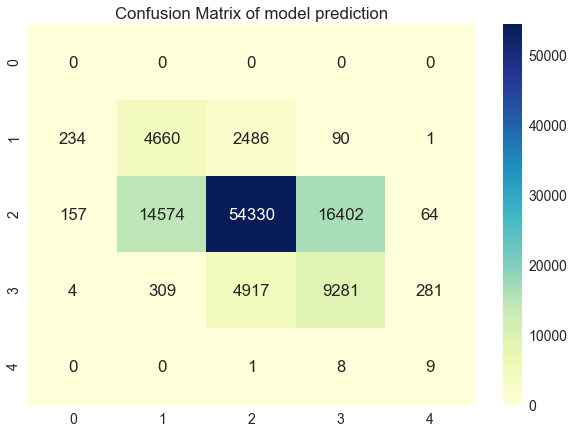

In [71]:
draw_confusion_matrix(prediction, reviews_text_mining['ranking'])